In [4]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_regression, mutual_info_regression


path = r"C:\Users\Surface\Masterarbeit\data\Produktionsdaten\WZ_2_Feature_Engineered_vorsortiert_Fynn1.xlsx"
#path = r"C:\Users\Surface\Masterarbeit\data\Produktionsdaten\WZ_2_Feature_Engineered_vorsortiert.xlsx"

prod_data_df = pd.read_excel(path)

In [5]:
#get some insights into the data
display(prod_data_df.describe())
display(prod_data_df.info())

# Check for categorial variables
number_unique = df.nunique(axis = 0).sort_values(ascending=False)
display(number_unique)

,C1_V01_delta_kan,BT_NR,STP_NR,Ist_Blechhaltergewicht,Ist_Gegenhaltekraft_HL_1,Ist_Stoesselverstellung-mm,Ist_Ziehkissenverstellung,Diff_Gewichtsausgleich,Diff_Hubzahl,Diff_Ziehtiefe,...,month_sin,month_cos,hour_sin,hour_cos,day_sin,day_cos,quarter_sin,quarter_cos,week_sin,week_cos
count,52013.000000,52013.000000,52013.000000,52013.000000,52013.000000,52013.000000,52013.00000,52013.000000,52013.000000,52013.000000,...,52013.000000,5.201300e+04,52013.000000,52013.000000,52013.000000,52013.000000,52013.000000,5.201300e+04,52013.000000,52013.000000
mean,115.016421,158.085229,5.113702,0.007114,714.660719,1174.993290,149.99106,0.447315,-0.840002,0.141422,...,-0.220147,-3.349107e-01,-0.204866,0.058917,-0.168444,0.131998,-0.310365,-1.827235e-01,-0.133125,-0.396852
std,7.621156,94.645919,3.175297,0.188462,2.803588,0.069343,0.04080,0.068352,1.019945,2.005954,...,0.797753,4.505289e-01,0.696323,0.685355,0.716318,0.664162,0.849096,3.864434e-01,0.768097,0.484592
min,59.203040,1.000000,0.000000,0.000000,700.000000,1174.900000,149.90000,0.000000,-9.000000,-18.200000,...,-1.000000,-1.000000e+00,-1.000000,-1.000000,-0.998717,-0.994869,-1.000000,-1.000000e+00,-0.996050,-0.998244
25%,110.602900,77.000000,2.000000,0.000000,713.000000,1174.900000,150.00000,0.400000,-2.100000,0.000000,...,-1.000000,-8.660254e-01,-0.866025,-0.500000,-0.724793,-0.612106,-1.000000,-1.836970e-16,-0.902798,-0.915146
50%,114.982600,152.000000,5.000000,0.000000,713.000000,1175.000000,150.00000,0.400000,-0.200000,0.000000,...,-0.500000,-1.836970e-16,-0.500000,0.258819,-0.485302,0.151428,-1.000000,-1.836970e-16,-0.059241,-0.430065
75%,120.784900,237.000000,8.000000,0.000000,717.000000,1175.000000,150.00000,0.500000,-0.100000,0.300000,...,0.866025,6.123234e-17,0.258819,0.707107,0.651372,0.820763,1.000000,6.123234e-17,0.875735,0.029633
max,140.684000,349.000000,14.000000,5.000000,725.000000,1175.100000,150.10000,0.900000,3.400000,3.000000,...,1.000000,5.000000e-01,1.000000,1.000000,0.998717,0.918958,1.000000,6.123234e-17,0.999561,0.482792


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52013 entries, 0 to 52012
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   C1_V01_delta_kan            52013 non-null  float64
 1   BT_NR                       52013 non-null  int64  
 2   STP_NR                      52013 non-null  int64  
 3   Ist_Blechhaltergewicht      52013 non-null  int64  
 4   Ist_Gegenhaltekraft_HL_1    52013 non-null  int64  
 5   Ist_Stoesselverstellung-mm  52013 non-null  float64
 6   Ist_Ziehkissenverstellung   52013 non-null  float64
 7   Diff_Gewichtsausgleich      52013 non-null  float64
 8   Diff_Hubzahl                52013 non-null  float64
 9   Diff_Ziehtiefe              52013 non-null  float64
 10  T24                         52013 non-null  int64  
 11  PP_10                       52013 non-null  float64
 12  TT_10                       52013 non-null  float64
 13  TM5_10                      520

None

RF_10                         494
BT_NR                         349
TM5_10                        318
TT_10                         290
PP_10                         226
TD_10                         189
T24                           154
C1_V01_delta_kan              126
Diff_Hubzahl                   45
hour_cos                       22
hour_sin                       21
day_sin                        20
week_sin                       17
Diff_Ziehtiefe                 16
day_cos                        16
week_cos                       15
STP_NR                         15
Ist_Gegenhaltekraft_HL_1        8
Diff_Gewichtsausgleich          8
month_sin                       7
month_cos                       7
dayofweek_sin                   6
dayofweek_cos                   6
Ist_Stoesselverstellung-mm      3
Ist_Ziehkissenverstellung       3
quarter_sin                     3
quarter_cos                     3
is_weekend                      2
Ist_Blechhaltergewicht          2
dtype: int64

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_regression, SelectKBest
import numpy as np

# Define the target variable
target = 'C1_V01_delta_kan'

X = df.drop(columns=[target]) #.to_numpy()
y = df[target] #.to_numpy()

f_statistic, p_value = f_regression(X, y)

print(f"F-statistic: {f_statistic}")
print(f"P-values: {p_value}")

X_new = SelectKBest(f_regression, k=15).fit_transform(X, y)
# get the feature names of the selected features
print(X_new.shape)
selected_features = X.columns[SelectKBest(f_regression, k=15).fit(X, y).get_support()]
print("Selected features:", selected_features)

F-statistic: [2.61667355e+02 1.68704455e+01 4.12909441e+00 2.16272524e+02
 7.85859921e+01 1.73524082e+03 1.75461014e+02 6.22429108e+02
 5.48057091e+02 2.49535616e+02 8.92347464e+02 2.55157300e+02
 1.41581986e+02 2.86905368e+01 5.17482605e+02 4.66278866e+02
 1.94372732e+03 3.66794784e+02 2.11796510e+03 8.24009048e+03
 5.50699399e+01 4.49932068e+02 1.12999301e+01 1.87566726e+01
 1.32668619e+03 4.33827958e+03 3.08792940e+03 4.22851934e+03]
P-values: [1.03423347e-058 4.00810357e-005 4.21569735e-002 7.37466362e-049
 7.89551368e-019 0.00000000e+000 5.51297845e-040 1.41371820e-136
 1.40467548e-120 4.42882164e-056 2.00711101e-194 2.67099168e-057
 1.32324740e-032 8.52773983e-008 5.39157620e-114 5.86977780e-103
 0.00000000e+000 1.78294645e-081 0.00000000e+000 0.00000000e+000
 1.18085031e-013 1.97215095e-099 7.75658006e-004 1.48780444e-005
 7.45357238e-287 0.00000000e+000 0.00000000e+000 0.00000000e+000]
(52013, 15)
Selected features: Index(['Ist_Ziehkissenverstellung', 'Diff_Hubzahl', 'Diff_Zieh

Korrelationsmatrix

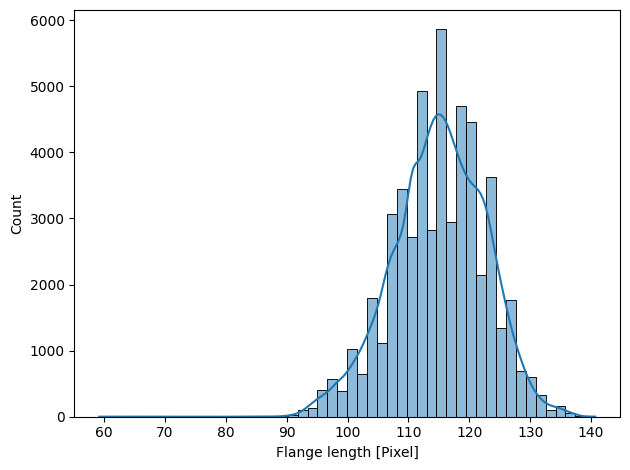

Mean: 115.01642119239422
std deviation: 7.621156305964063


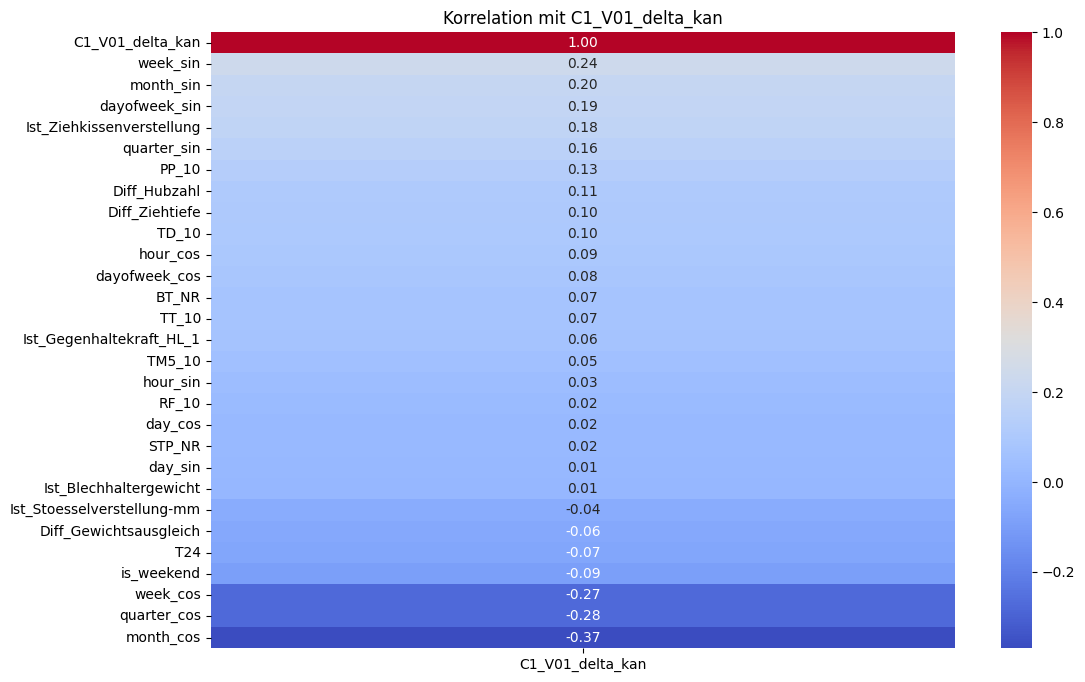

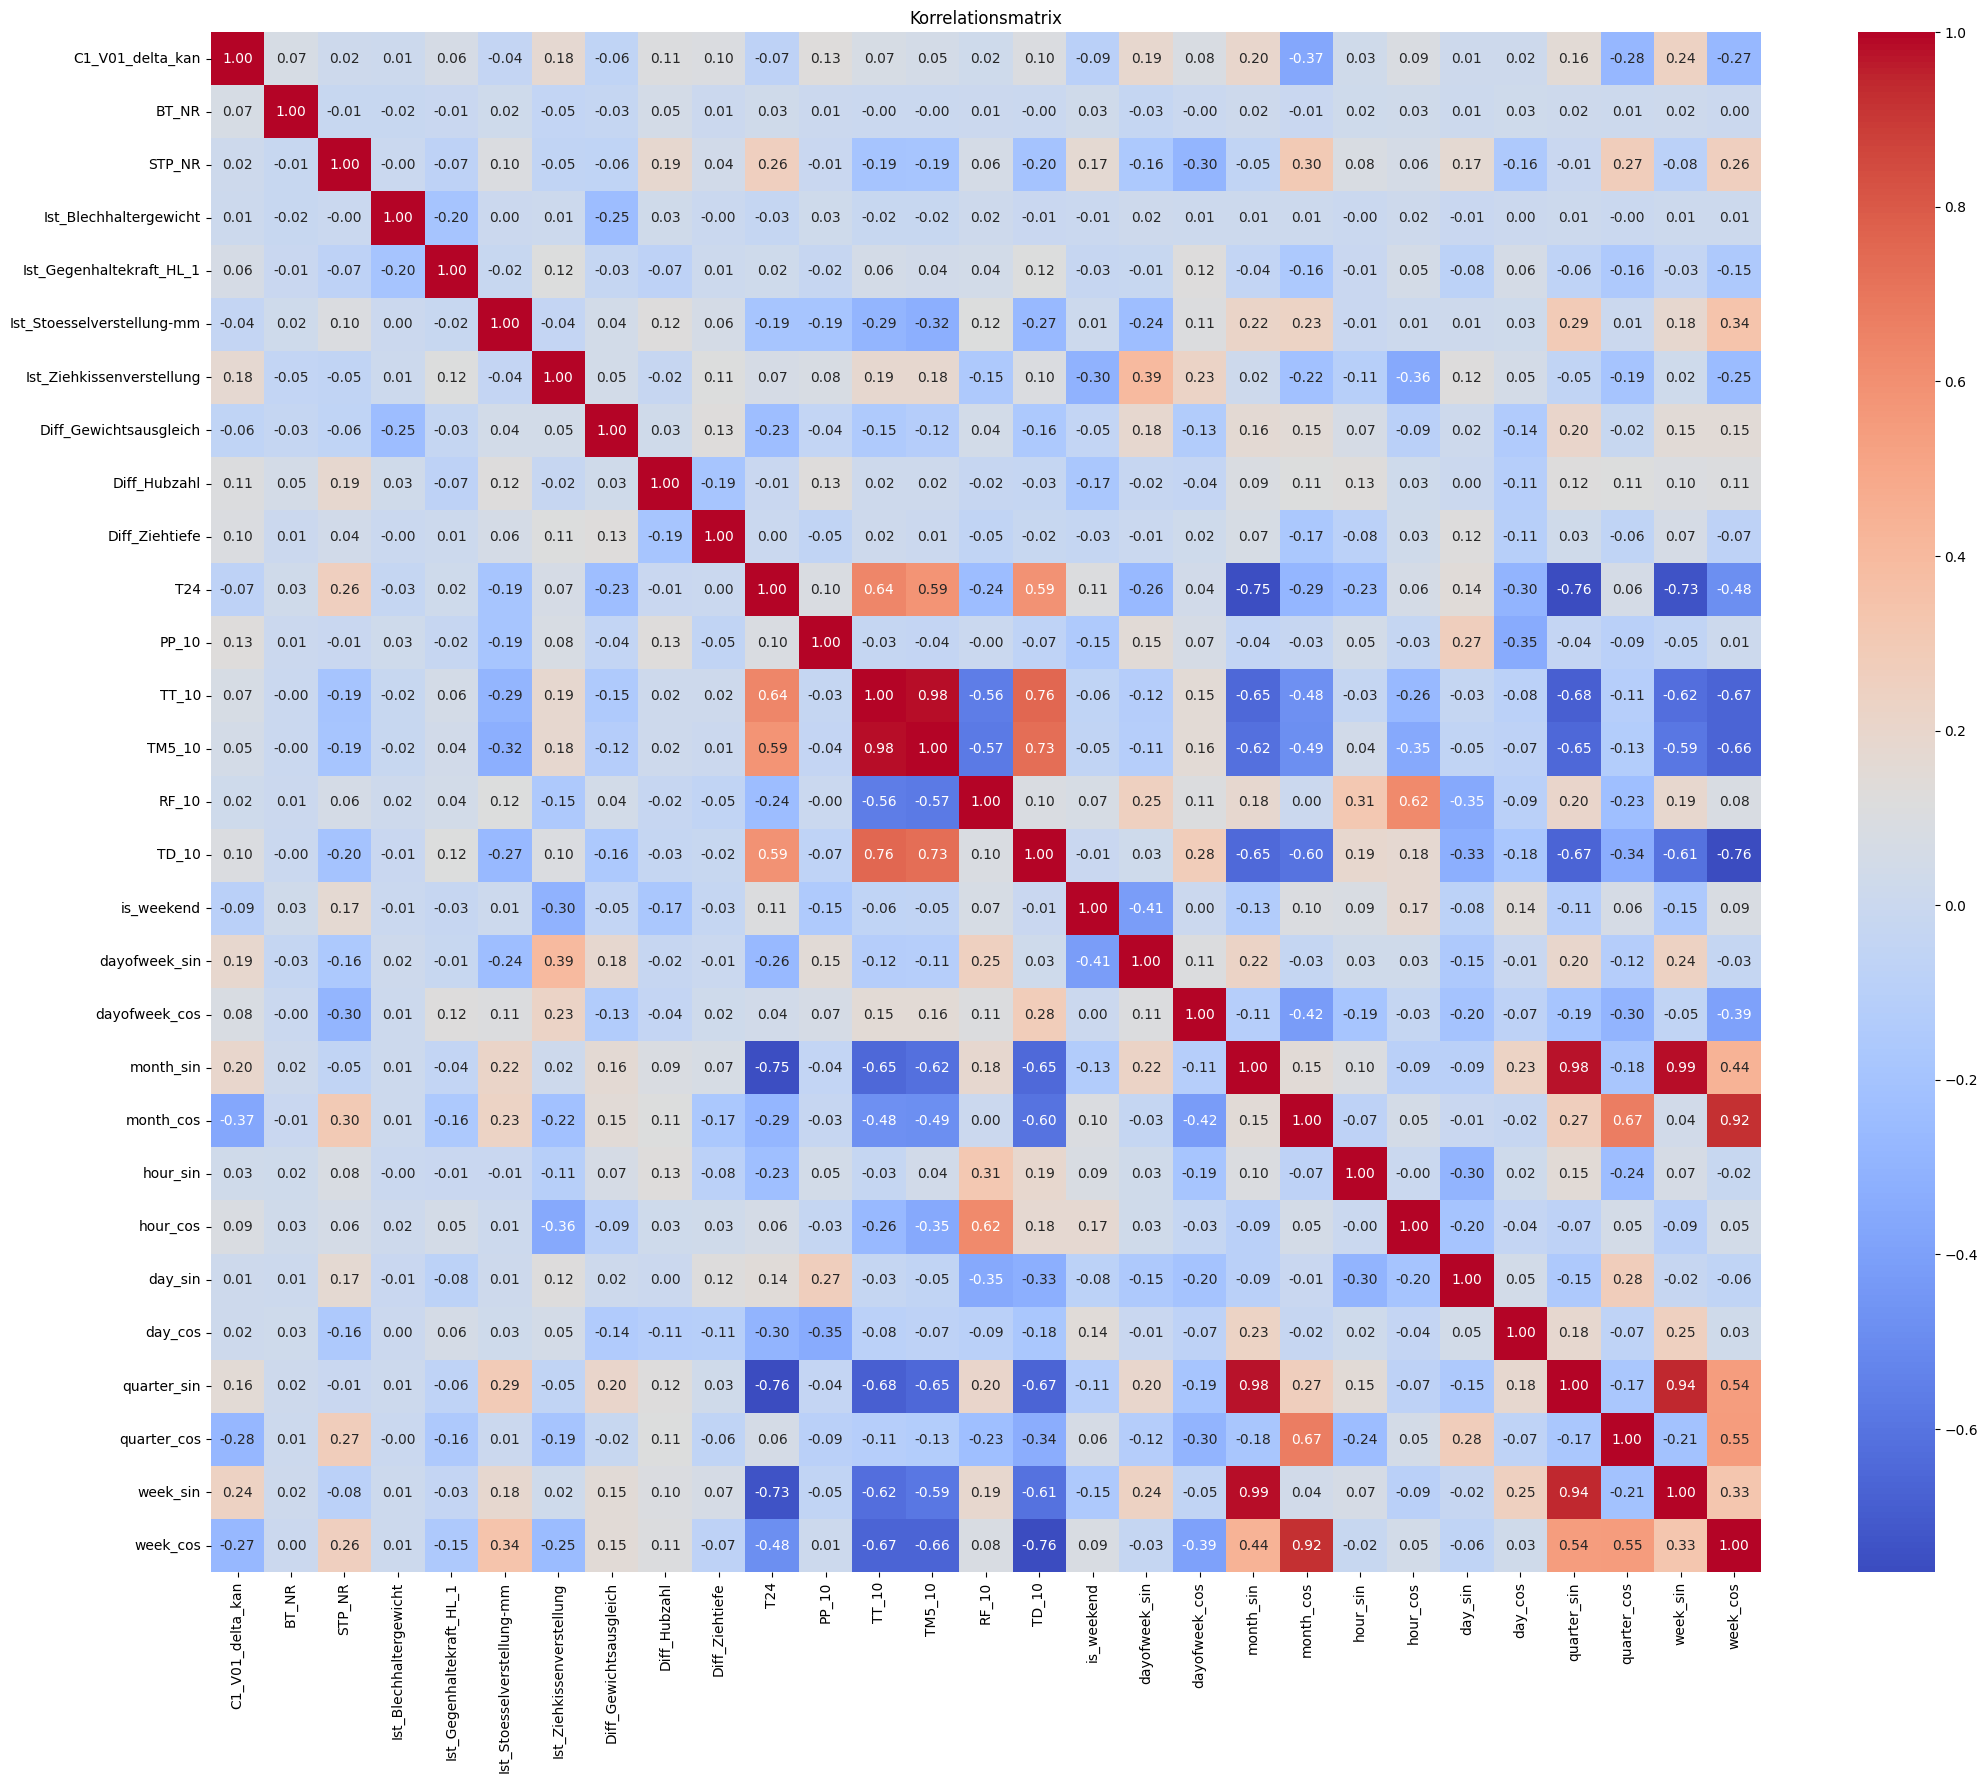

In [ ]:



df1 = df

# Convert categorical variables to frequency encoding
# Define categorical variables
cat_vars = ['BT_NR', 'STP_NR']
# loop through each categorical variable
# for var in cat_vars:
#     # frequency of each category
#     freq = df1[var].value_counts()
#     # map the freqency to the orginal dataframe
#     df1[var + '_freq'] = df1[var].map(freq)
#     # drop the original categorical variable
#     df1.drop(var, axis=1, inplace=True)

# Korrelationmatrix nach Pearson, Annahme Daten haben lineare Korrelation
corr = df1.corr('pearson')

# definiere Target Variable
target = 'C1_V01_delta_kan'
# Korrelationsmatrix für die Target Variable, absteigend sortiert
corr_matrix = corr[target].sort_values(ascending=False)

# plot the target data distribution
sns.histplot(df[target], bins=50, kde=True)
plt.xlabel('Flange length [Pixel]')  # Ändere hier die X-Achsen-Beschriftung
plt.tight_layout()
plt.savefig(os.path.join("C:\\Users\\Surface\\OneDrive\\Master Management und Engineering\\Masterarbeit\\Experimente", "Target distribution.svg"), format ='svg')
plt.show()
print(f'Mean: {df[target].mean()}')
print(f'std deviation: {df[target].std()}')

# plot the correlation matrix for the target variable
plt.figure(figsize=(12, 8))
# corr_matrix.to_frame because corr_matrix is a Series
# annot = True to show the correlation values
# fmt = for the numbers after the comma
sns.heatmap(corr_matrix.to_frame(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title(f'Korrelation mit {target}')
plt.show()

#plot the correlation matrix for all variables
plt.figure(figsize=(25, 20))
sns.heatmap(corr, annot=True, cmap='coolwarm',  fmt='.2f')
plt.title('Korrelationsmatrix')
plt.show()


First Filter for Feature Selection
F_Regression for linear Relationship:

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html#sklearn.feature_selection.f_regression

Mutual information for any Relationship:

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html#sklearn.feature_selection.
mutual_info_regression

Comparision of both

https://scikit-learn.org/stable/auto_examples/feature_selection/plot_f_test_vs_mi.html


In [ ]:
# use f_regression and mutual_info_regression to calculate the feature importance
# f_regression is a statistical test that calculates the F-value and p-value for each feature, 
# it captures the linear relationship between the features and the target variable 
# mutual_info_regression captures any kind of relationship, linear or non-linear, between the features and the target variable
# both methods are used to determine the importance of each feature in relation to the target variable
# calculate the F-values and p-values for each feature
# f_regression returns the F-values and p-values for each feature
f_vals, p_vals = f_regression(X_full, y_full)
mi_vals = mutual_info_regression(X_full, y_full, n_jobs = -1)

# create a dataframe with the feature names and the mutual information scores and f-values
feature_scores_MI = pd.DataFrame({
    'Feature': feature_names,
    'Mutual Information': mi_vals,
})
feature_scores_F = pd.DataFrame({
    'Feature': feature_names,
    'F_value': f_vals,
    'P_value': p_vals
})
# sort the feature scores by mutual information and F-value
feature_scores_MI_sorted = feature_scores_MI.sort_values(by='Mutual Information', ascending=False)
feature_scores_F_sorted = feature_scores_F.sort_values(by='F_value', ascending=False)
# merge the two dataframes on the feature names to get a combined view of the feature importance
feature_scores = pd.merge(feature_scores_MI_sorted, feature_scores_F_sorted, on='Feature')

# list to store features with low scores
low_feature_scores =[]

# plot the feature importance using mutual information and F-value in a scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(feature_scores['Mutual Information'], feature_scores['F_value'])
plt.xlabel('Mutual Information')
plt.ylabel('F-value')
plt.title('Feature Importance: Mutual Information vs F-value')
plt.grid(True)

# Annotate and save the points with low feature scores in a list
for i, row in feature_scores.iterrows():
    if row['Mutual Information'] < 0.03 and row['F_value'] < 10:
        low_feature_scores.append(row['Feature'])
        plt.annotate(row['Feature'], (row['Mutual Information'], row['F_value']), fontsize=8)
        
plt.show()
